In [1]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold, KFold
import numpy as np
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import imblearn
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, fbeta_score, plot_confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import make_scorer
from sklearn.svm import SVC
from sklearn import metrics

In [2]:
trainingData = pd.read_csv('Data/TRAIN_ExtractedFeatures&LABEL.csv')
X = trainingData.loc[:, trainingData.columns != 'LABEL']
y = trainingData['LABEL']

In [42]:
#CALCULO DE MEDIA DE LAS METRICAS SOBRE TODAS LAS PARTICIONES CROSS VALIDATION

cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)
scoring = {"recall": "recall","precision":"precision", "f4": make_scorer(fbeta_score,beta=4)}

#NORMAL TRAINING
pipeline = make_pipeline(StandardScaler(), SVC(C=1, kernel='linear'))

scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.8142857142857143 +- 0.10449099170234137
Precision:
Test: 0.975 +- 0.049999999999999996
Puntuación f4:
 Test: 0.8209914465049805 +- 0.09705238287378337


In [17]:
#TRAINING WITH SMOTE
model = make_pipeline(StandardScaler(), SVC(C=1, kernel='linear'))
over = SMOTE(sampling_strategy=1,random_state=10)
steps = [('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.7392857142857143 +- 0.2075119863761993
Precision:
Test: 0.6146969696969696 +- 0.04071108083613906
Puntuación f4:
 Test: 0.7272119621996962 +- 0.19477988608214122


In [18]:
#TRAINING WITH UNDERSAMPLING + SMOTE USANDO EL VALOR ANTERIOR
model = make_pipeline(StandardScaler(), SVC(C=1, kernel='linear'))
over = SMOTE(sampling_strategy=1,random_state=10)
under = RandomUnderSampler(sampling_strategy=0.01,random_state=10)
steps = [('under', under), ('over', over), ('model', model)]
pipeline = Pipeline(steps=steps)

scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.7392857142857143 +- 0.2075119863761993
Precision:
Test: 0.6977777777777778 +- 0.1654996176937884
Puntuación f4:
 Test: 0.7281200340159318 +- 0.19185538554015974


In [54]:
#USE CROSS VALIDATION TO FIND BEST C
pipeline = make_pipeline(StandardScaler(), SVC(C=1, kernel='linear'))
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)
scoring = {"recall": "recall","precision":"precision", "f4": make_scorer(fbeta_score,beta=4)}
grid = GridSearchCV(pipeline, param_grid={'svc__C':np.linspace(0.2,1,5)}, 
                    cv = cv, scoring=scoring,return_train_score=True,refit='f4')

fitted = grid.fit(X,y)

pd.DataFrame(grid.cv_results_)[['mean_test_recall', 'std_test_recall', 'mean_test_precision', 'std_test_precision',
                                'mean_test_f4', 'std_test_f4','params']]

,mean_test_recall,std_test_recall,mean_test_precision,std_test_precision,mean_test_f4,std_test_f4,params
0,0.839286,0.101015,0.975000,0.050000,0.845049,0.094112,{'svc__C': 0.2}
1,0.839286,0.101015,0.975000,0.050000,0.845049,0.094112,{'svc__C': 0.4}
2,0.814286,0.104491,0.955556,0.088889,0.819352,0.094183,{'svc__C': 0.6000000000000001}
3,0.814286,0.104491,0.975000,0.050000,0.820991,0.097052,{'svc__C': 0.8}
4,0.814286,0.104491,0.975000,0.050000,0.820991,0.097052,{'svc__C': 1.0}


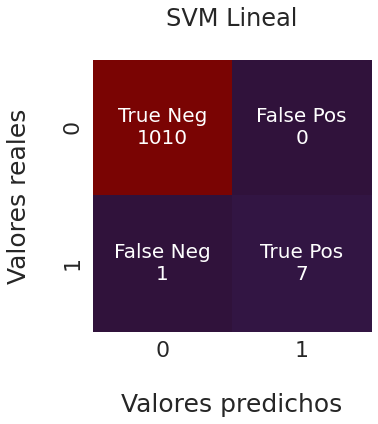

In [61]:
#CONFUSION MATRIX IN TRAINING (en una iteración de la validacion cruzada)

clf = make_pipeline(StandardScaler(), SVC( kernel='linear',C=0.2))
cv = StratifiedKFold(n_splits=5,shuffle=True, random_state=10)

for train_index, test_index in cv.split(X, y):
    X_train, y_train = X.iloc[train_index], y.iloc[train_index]
    clf.fit(X_train,y_train)
    y_test = y.iloc[test_index].array
    y_pred = clf.predict(X.iloc[test_index])
    break
    

matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 2)
ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='turbo',cbar=False, annot_kws={"size": 20})

ax.set_title('SVM Lineal\n')
ax.set_xlabel('\nValores predichos',fontsize=25)
ax.set_ylabel('Valores reales\n',fontsize=25)
sns.set(font_scale=10)

ax.figure.savefig('CM Training/CM_SVM_Linear.png', dpi=1000, bbox_inches="tight")


In [49]:
clf = fitted.best_estimator_
scores = cross_validate(clf, X, y, cv=cv, scoring=scoring)
print('Recall:\n Test:', scores['test_recall'].mean() , '+-', scores['test_recall'].std())
print('Precision:\nTest:', scores['test_precision'].mean(), '+-', scores['test_precision'].std())
print('Puntuación f4:\n Test:', scores['test_f4'].mean(), '+-', scores['test_f4'].std())

Recall:
 Test: 0.8392857142857142 +- 0.10101525445522107
Precision:
Test: 0.975 +- 0.049999999999999996
Puntuación f4:
 Test: 0.8450489368311276 +- 0.09411198031746237


In [57]:
#PRUEBA EN EL CONJUNTO DE TEST
testData = pd.read_csv('Data/TEST_ExtractedFeatures&LABEL.csv')
X_test = testData.loc[:, testData.columns != 'LABEL']
y_test = testData['LABEL']
from sklearn.metrics import precision_recall_curve, auc

clf = fitted.best_estimator_
y_pred = clf.predict(X_test)
print('precision:',precision_score(y_test, y_pred, average='binary')) # TP / (TP + FP)
print('recall:',recall_score(y_test, y_pred, average='binary')) # TP / (TP + FN)
print('f4:',fbeta_score(y_test, y_pred, beta=4, average="binary"))
precision, recall, _  = precision_recall_curve(y_test, clf.decision_function(X_test))
print('PR AUC:',auc(recall, precision))

precision: 1.0
recall: 0.6
f4: 0.6144578313253011
PR AUC: 0.6039013617322935


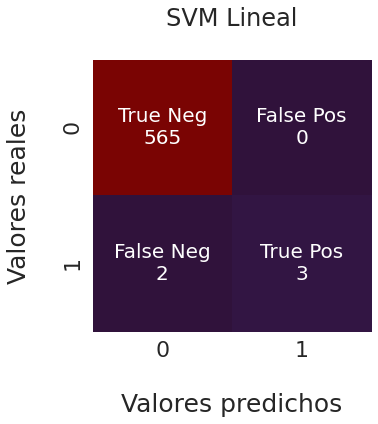

In [59]:
#CONFUSION MATRIX
matrix = confusion_matrix(y_test, y_pred)

group_names = ['True Neg','False Pos','False Neg','True Pos']

group_counts = ["{0:0.0f}".format(value) for value in
                matrix.flatten()]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_names,group_counts)]

labels = np.asarray(labels).reshape(2,2)

sns.set(rc={'figure.figsize':(5,5)})
sns.set(font_scale = 2)
ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='turbo',cbar=False, annot_kws={"size": 20})

ax.set_title('SVM Lineal\n')
ax.set_xlabel('\nValores predichos',fontsize=25)
ax.set_ylabel('Valores reales\n',fontsize=25)
sns.set(font_scale=10)

ax.figure.savefig('CM Test/CM_SVM_Linear.png', dpi=1000, bbox_inches="tight")